# Data Preprocessing

In [23]:
import numpy as np
import os
import cv2
import tensorflow as tf
import pickle
from random import shuffle
import matplotlib.pyplot as plt
import datetime
from sklearn.cluster import KMeans
from collections import Counter
from skimage.color import rgb2lab, deltaE_cie76
from collections import Counter
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

In [16]:
dataset = os.path.join(os.getcwd(), "pdataset")
data = []
classes = 0
for i , value in enumerate(os.listdir(dataset)):
    f_dir = os.path.join(dataset,value)
    for c_dir in os.listdir(f_dir):
        for each in os.listdir(f"{f_dir}/{c_dir}"):
            image = cv2.imread(f"{f_dir}/{c_dir}/{each}",0)
            image = cv2.resize(image,(200,200))
            data.append((image,classes))
        classes +=1
        print(classes)

1
2
3
4
5
6
7
8
9
10
11
12


In [17]:
shuffle(data)
x = []
y = []
for features , label in data:
    x.append(features)
    y.append(label)
x = np.array(x).reshape(-1,200,200,1)
pickle_out = open("X.pickle","wb")
pickle.dump(x,pickle_out)
pickle_out.close()

pickle_out = open("Y.pickle","wb")
pickle.dump(y,pickle_out)
pickle_out.close()

# Training

In [18]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

In [19]:
pickle_in = open("X.pickle", "rb")
X = pickle.load(pickle_in)

pickle_in = open("y.pickle", "rb")
y = pickle.load(pickle_in)

X = X/255.0

model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=X.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))



model.add(Flatten())  

model.add(Dense(64))

model.add(Dense(12))
model.add(Activation('sigmoid'))


model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

logdir = "logs\\scalars\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
model.fit(X, y, batch_size=32, epochs=20, validation_split=0.3)

model.save("model.h5")

Train on 3242 samples, validate on 1390 samples
Epoch 1/20
3242/3242 [==============================] - 9s 3ms/sample - loss: 1.9015 - acc: 0.2301 - val_loss: 1.6552 - val_acc: 0.3094
Epoch 2/20
3242/3242 [==============================] - 9s 3ms/sample - loss: 1.3820 - acc: 0.4362 - val_loss: 1.5364 - val_acc: 0.3986
Epoch 3/20
3242/3242 [==============================] - 9s 3ms/sample - loss: 0.6418 - acc: 0.7613 - val_loss: 1.7001 - val_acc: 0.3698
Epoch 4/20
3242/3242 [==============================] - 9s 3ms/sample - loss: 0.1464 - acc: 0.9550 - val_loss: 2.4097 - val_acc: 0.3655
Epoch 5/20
3242/3242 [==============================] - 9s 3ms/sample - loss: 0.0473 - acc: 0.9914 - val_loss: 2.3618 - val_acc: 0.3806
Epoch 6/20
3242/3242 [==============================] - 9s 3ms/sample - loss: 0.0109 - acc: 0.9985 - val_loss: 2.4484 - val_acc: 0.3856
Epoch 7/20
3242/3242 [==============================] - 9s 3ms/sample - loss: 0.0067 - acc: 0.9994 - val_loss: 2.5972 - val_acc: 0.3957


# Testing

In [9]:
model = tf.keras.models.load_model('model.h5')
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 198, 198, 32)      320       
_________________________________________________________________
activation_10 (Activation)   (None, 198, 198, 32)      0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 97, 97, 32)        9248      
_________________________________________________________________
activation_11 (Activation)   (None, 97, 97, 32)        0         
________________

In [10]:
from matplotlib import pyplot as plt
%matplotlib inline

In [11]:
def process(path):
    results = []
    image = cv2.imread(path,1)
    frame = image.copy()    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w, _ = image.shape
    w_new = int(100 * w / max(w, h) )
    h_new = int(100 * h / max(w, h) )
    image = cv2.resize(image, (w_new, h_new));
    image_array = image.reshape((image.shape[0] * image.shape[1], 3))
    clf = KMeans(n_clusters = 20)
    clf.fit(image_array)
    r_colors = [ int(each[0]) for each in clf.cluster_centers_]
    r_colors.sort()
    pairs = []
    for i in range(len(r_colors)-1):
        pairs.append((r_colors[i],r_colors[i+1]))
    for i , value in enumerate(pairs):
        lo, hi = value[0],value[1]
        lower_blue = np.array([lo-1, lo-1, lo-1])
        upper_blue = np.array([hi+1,hi+1, hi+1])
        mask = cv2.inRange(frame, lower_blue, upper_blue)
        r = np.full((frame.shape[1], frame.shape[0],1),lo)
        g = np.full((frame.shape[1], frame.shape[0],1),255)
        b = np.full((frame.shape[1], frame.shape[0],1),hi)
        arr = np.dstack((r,g,b))
        result = cv2.bitwise_or(arr, arr, mask = mask)
        plt.imshow(result)
        plt.show()
        result = np.array(result).reshape(-1,200,200,1)
        results.append(model.predict_classes(result))
        
    return results
        

In [21]:
def ptest(path):
    image = cv2.imread(path,0)
    image = cv2.resize(image,(200,200))
    x = np.array(image).reshape(-1,200,200,1)
    y = model.predict_classes(x)
    return y[0][0]

normal expected 0 : observerd ->


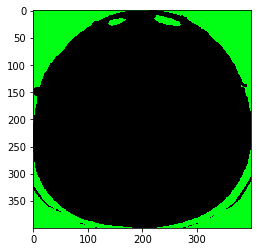

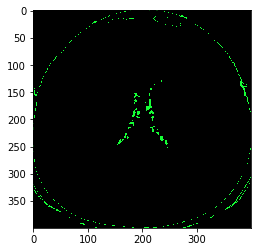

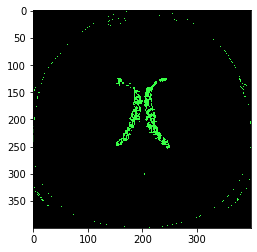

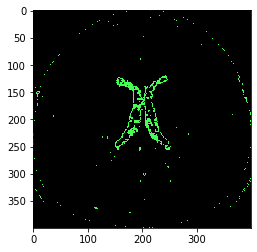

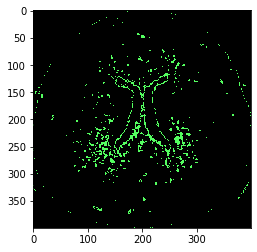

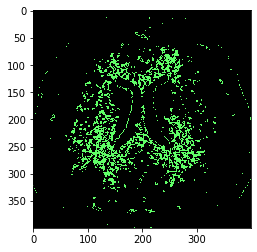

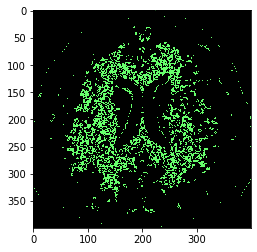

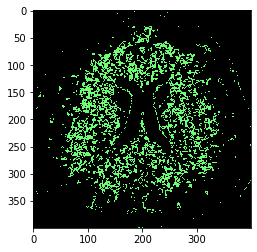

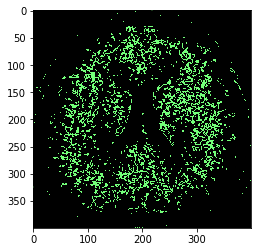

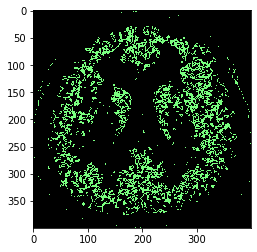

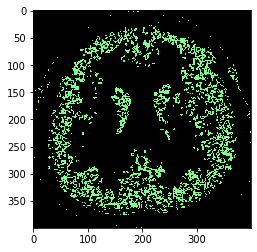

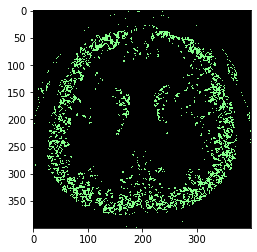

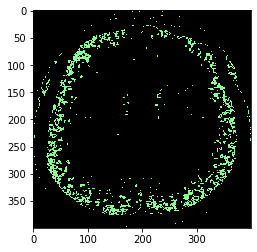

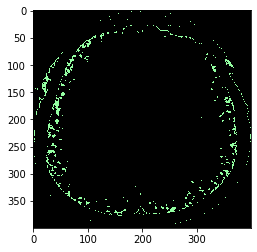

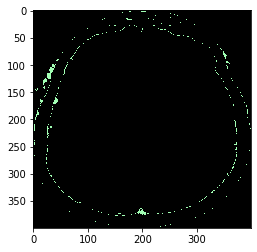

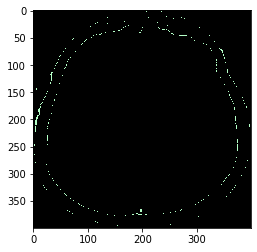

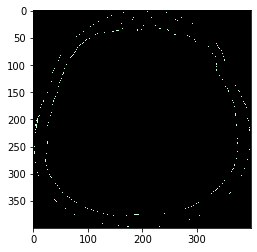

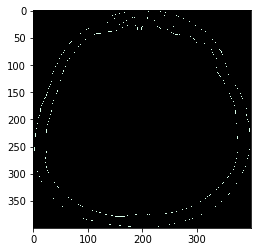

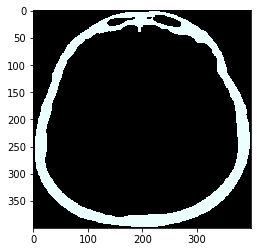

26.jpg  ->  [array([4, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0], dtype=int64), array([ 0,  0, 10,  4,  0,  0,  0,  4,  3,  0,  0,  0], dtype=int64), array([ 0,  3, 10,  4,  0,  0,  0,  6,  1,  0,  0,  5], dtype=int64), array([0, 4, 7, 0, 0, 0, 0, 6, 6, 0, 0, 5], dtype=int64), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5], dtype=int64), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3], dtype=int64), array([4, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5], dtype=int64), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3], dtype=int64), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3], dtype=int64), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3], dtype=int64), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3], dtype=int64), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3], dtype=int64), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64), array([0, 0, 3, 0, 0, 0, 0, 5, 0, 0, 0, 0], dtype=int64), array([0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0], dtype=int64), array([0, 0, 3, 0, 4, 0, 0, 4, 0, 0

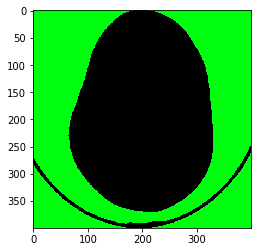

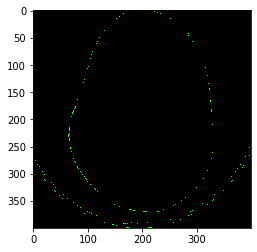

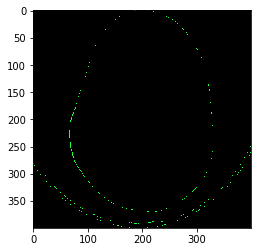

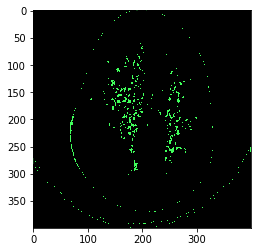

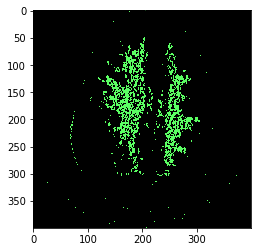

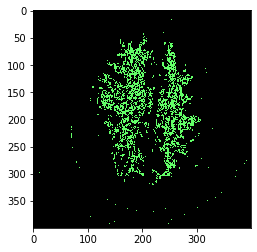

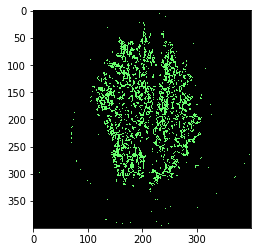

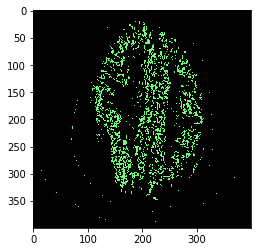

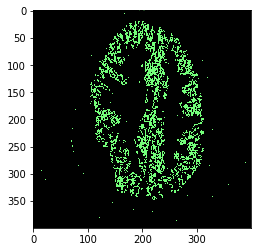

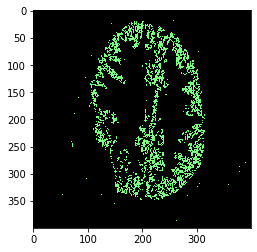

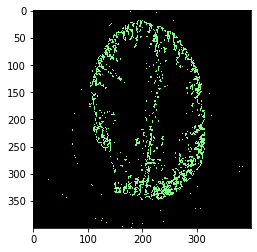

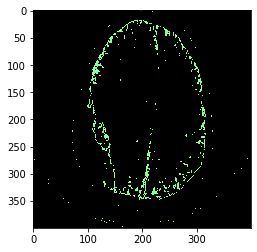

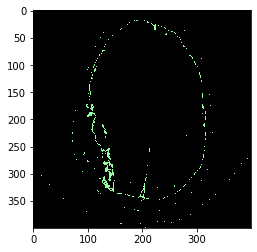

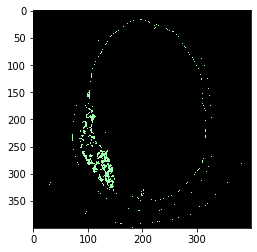

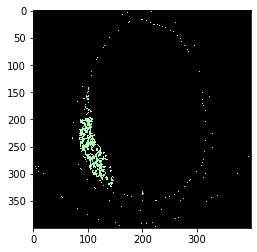

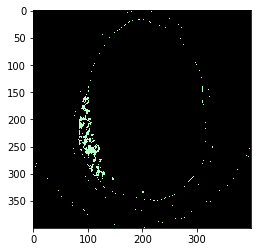

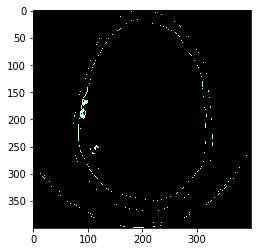

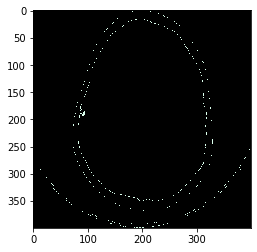

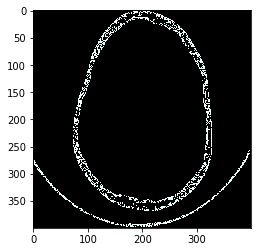

103.jpg  ->  [array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4], dtype=int64), array([1, 0, 4, 4, 0, 3, 3, 3, 3, 0, 0, 0], dtype=int64), array([1, 4, 4, 7, 9, 3, 6, 0, 3, 0, 0, 0], dtype=int64), array([1, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64), array([8, 3, 0, 0, 0, 0, 0, 0, 0, 0, 9, 4], dtype=int64), array([3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0], dtype=int64), array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8], dtype=int64), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64), array([9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4], dtype=int64), array([4, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0], dtype=int64), array([4, 0, 0, 1, 0, 0, 0, 3, 0, 0, 0, 0], dtype=int64), array([3, 3, 3, 4, 1, 0, 0, 0, 0, 0, 3, 0], dtype=int64), array([ 0,  3,  0,  2, 10,  0,  0,  0,  0,  2,  0,  8], dtype=int64), array([0, 0, 0, 2, 0, 4, 0, 0, 0, 0, 0, 0], dtype=int64), array([0, 3, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0], dt

In [20]:
for i , each in enumerate(os.listdir("ptest")):
    print(each,f"expected {i} : observerd ->")

    for file in os.listdir(f"ptest/{each}"):
        print(file," -> ",process(f"ptest/{each}/"+file))
        break
        


(3, 198, 198, 32)
(3, 99, 99, 32)
(3, 97, 97, 32)
(3, 97, 97, 32)
(3, 48, 48, 32)
(3, 73728)
(3, 64)
(3, 12)
(3, 12)


C:\Users\kabil\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


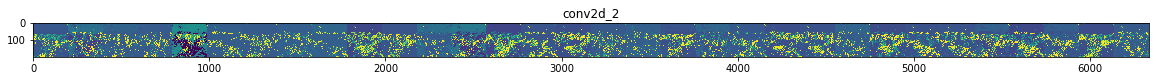

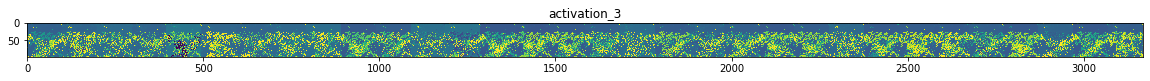

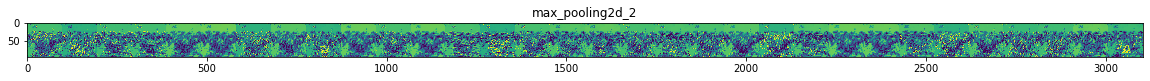

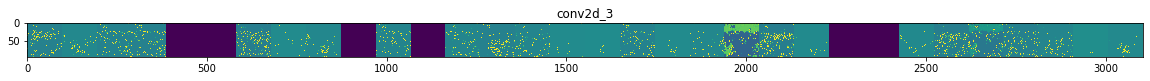

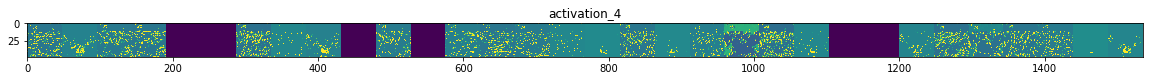

In [26]:
img_path = r"C:\Users\kabil\Desktop\stoke-prediction\multiprocessing\pdataset\stroke\10_class\2.jpg"

successive_outputs = [layer.output for layer in model.layers[1:]]
#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)
#Load the input image
img = load_img(img_path, target_size=(200, 200))
# Convert ht image to Array of dimension (150,150,3)
x   = img_to_array(img)                           
x   = np.array(img).reshape(-1,200,200,1)
# Rescale by 1/255
x = x/ 255.0
# Let's run input image through our vislauization network
# to obtain all intermediate representations for the image.
successive_feature_maps = visualization_model.predict(x)
# Retrieve are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  print(feature_map.shape)
  if len(feature_map.shape) == 4:
    
    # Plot Feature maps for the conv / maxpool layers, not the fully-connected layers
   
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    # Postprocess the feature to be visually palatable
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      # Tile each filter into a horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
# Display the grid
    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' )
    cv2.imwrite(f"{layer_name}.png",display_grid)